In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import MiniBatchKMeans
import geopandas as gpd

In [3]:
df = pd.read_csv('clean_data.csv')
df

,LGA,hhsize,totalvehs,hhinc,hhsize_normalised,totalvehs_normalised,hhinc_normalised,dwelltype_Flat or Apartment,dwelltype_Other,dwelltype_Separate House,dwelltype_Terrace/Townhouse,owndwell_Being Purchased,owndwell_Being Rented,owndwell_Fully Owned,owndwell_Occupied Rent-Free,owndwell_Something Else
0,Banyule,1.0,1.0,900.0,0.0,0.25,0.300801,0,1,0,0,0,0,1,0,0
1,Banyule,1.0,1.0,3625.0,0.0,0.25,0.899900,0,0,1,0,1,0,0,0,0
2,Banyule,2.0,1.0,1475.0,0.2,0.25,0.490991,0,0,1,0,0,0,1,0,0
3,Banyule,1.0,1.0,0.0,0.0,0.25,0.000000,0,0,1,0,1,0,0,0,0
4,Banyule,2.0,1.0,1225.0,0.2,0.25,0.416416,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854691,YarraRanges,1.0,0.0,2500.0,0.0,0.00,0.734735,0,0,1,0,1,0,0,0,0
1854692,YarraRanges,2.0,1.0,900.0,0.2,0.25,0.300801,0,0,1,0,0,0,1,0,0
1854693,YarraRanges,5.0,2.0,5000.0,0.8,0.50,0.966466,0,0,1,0,0,0,1,0,0
1854694,YarraRanges,4.0,2.0,4250.0,0.6,0.50,0.937938,0,0,1,0,0,0,1,0,0


In [4]:
df_norm = pd.DataFrame()
df_norm = df[['hhsize_normalised', 'totalvehs_normalised', 'hhinc_normalised','dwelltype_Separate House']].copy()
df_norm.loc[:, 'owndwell'] = df['owndwell_Fully Owned'] | df['owndwell_Being Purchased']
num_rows = df_norm.shape[0]
df_norm.head()

,hhsize_normalised,totalvehs_normalised,hhinc_normalised,dwelltype_Separate House,owndwell
0,0.0,0.25,0.300801,0,1
1,0.0,0.25,0.899900,1,1
2,0.2,0.25,0.490991,1,1
3,0.0,0.25,0.000000,1,1
4,0.2,0.25,0.416416,1,1


In [5]:
#sample_size = 1000000
#df_sample = df_norm.sample(sample_size, random_state=42)
#data = df_sample.values
data = df_norm.values


In [6]:
n_clusters = 10
batch_size = 3072
mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, n_init=10)
for i in range(0, len(data), batch_size):
    mbkmeans.partial_fit(data[i:i+batch_size])

In [7]:
labels = mbkmeans.predict(data)
df_norm['cluster'] = labels
df['cluster'] = labels
group_kmeans_norm = df_norm.groupby('cluster')
group_kmeans_norm.mean()

,hhsize_normalised,totalvehs_normalised,hhinc_normalised,dwelltype_Separate House,owndwell
cluster,,,,,
0,0.610322,0.533388,0.259426,1.0,1.0
1,0.210949,0.279878,0.500008,0.0,1.0
2,0.187676,0.269540,0.750497,0.0,0.0
3,0.207417,0.236724,0.764426,1.0,0.0
4,0.172250,0.211729,0.259324,1.0,1.0
5,0.172217,0.211980,0.755139,1.0,1.0
6,0.649199,0.565238,0.504264,1.0,0.0
7,0.187935,0.269084,0.254587,0.0,0.0
8,0.611494,0.533646,0.756074,1.0,1.0


In [8]:
group_kmeans_norm.size()/num_rows*100

cluster
0    12.347684
1    14.216022
2     7.523875
3     4.086600
4    17.702739
5    16.692169
6     3.986691
7     7.691126
8    11.531971
9     4.221123
dtype: float64

In [9]:
ev_label = 5
grouped = df.groupby(['LGA', 'cluster']).size().reset_index(name='count')
total = df['LGA'].value_counts()
count_df = df.groupby('LGA').apply(lambda x: x['cluster'].eq(ev_label).sum()).reset_index(name='count')
count_df['total'] = total.values
count_df['percent'] = round(count_df['count'] / count_df['total'], 2)

In [10]:
shapefile_folder = 'LGA_2022_AUST_GDA2020_SHP\LGA_2022_AUST_GDA2020.shp'
australia = gpd.read_file(shapefile_folder)

In [11]:
victoria = australia[australia["STE_NAME21"].str.startswith("V")]
victoria['LGA_NAME22'] = victoria['LGA_NAME22'].str.replace(' ', '')
victoria['LGA_NAME22'] = victoria['LGA_NAME22'].replace(to_replace=r'\(.*?\)', value='', regex=True)
merged_df = victoria.merge(count_df, left_on='LGA_NAME22', right_on='LGA', how='inner')

c:\Users\danla\anaconda3\envs\FYP\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


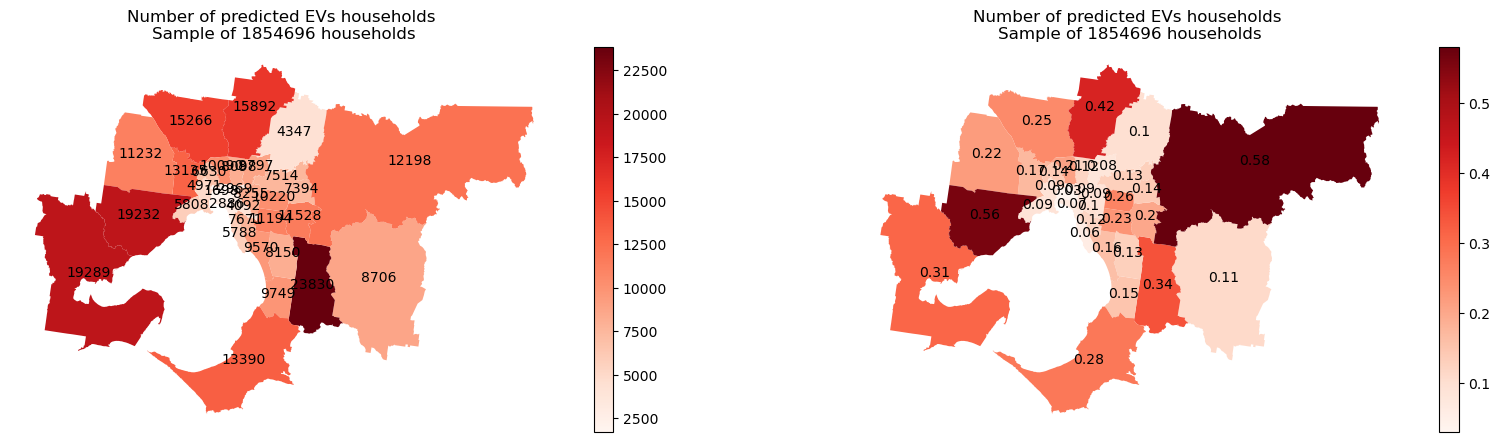

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

cmap = 'Reds'
merged_df.plot(ax=axs[0], column=merged_df["count"], cmap=cmap, legend=True)
for idx, row in merged_df.iterrows():
    axs[0].annotate(text=row["count"], xy=row["geometry"].centroid.coords[0], ha='center', color='black', fontsize=10)

axs[0].set_title(f'Number of predicted EVs households \nSample of {df.shape[0]} households')
axs[0].axis('off')

merged_df.plot(ax=axs[1], column=merged_df["percent"], cmap=cmap, legend=True)
for idx, row in merged_df.iterrows():
    axs[1].annotate(text=row["percent"], xy=row["geometry"].centroid.coords[0], ha='center', color='black', fontsize=10)

axs[1].set_title(f'Number of predicted EVs households \nSample of {df.shape[0]} households')
axs[1].axis('off')
plt.show()

In [13]:
df

,LGA,hhsize,totalvehs,hhinc,hhsize_normalised,totalvehs_normalised,hhinc_normalised,dwelltype_Flat or Apartment,dwelltype_Other,dwelltype_Separate House,dwelltype_Terrace/Townhouse,owndwell_Being Purchased,owndwell_Being Rented,owndwell_Fully Owned,owndwell_Occupied Rent-Free,owndwell_Something Else,cluster
0,Banyule,1.0,1.0,900.0,0.0,0.25,0.300801,0,1,0,0,0,0,1,0,0,1
1,Banyule,1.0,1.0,3625.0,0.0,0.25,0.899900,0,0,1,0,1,0,0,0,0,5
2,Banyule,2.0,1.0,1475.0,0.2,0.25,0.490991,0,0,1,0,0,0,1,0,0,4
3,Banyule,1.0,1.0,0.0,0.0,0.25,0.000000,0,0,1,0,1,0,0,0,0,4
4,Banyule,2.0,1.0,1225.0,0.2,0.25,0.416416,0,0,1,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854691,YarraRanges,1.0,0.0,2500.0,0.0,0.00,0.734735,0,0,1,0,1,0,0,0,0,5
1854692,YarraRanges,2.0,1.0,900.0,0.2,0.25,0.300801,0,0,1,0,0,0,1,0,0,4
1854693,YarraRanges,5.0,2.0,5000.0,0.8,0.50,0.966466,0,0,1,0,0,0,1,0,0,8
1854694,YarraRanges,4.0,2.0,4250.0,0.6,0.50,0.937938,0,0,1,0,0,0,1,0,0,8


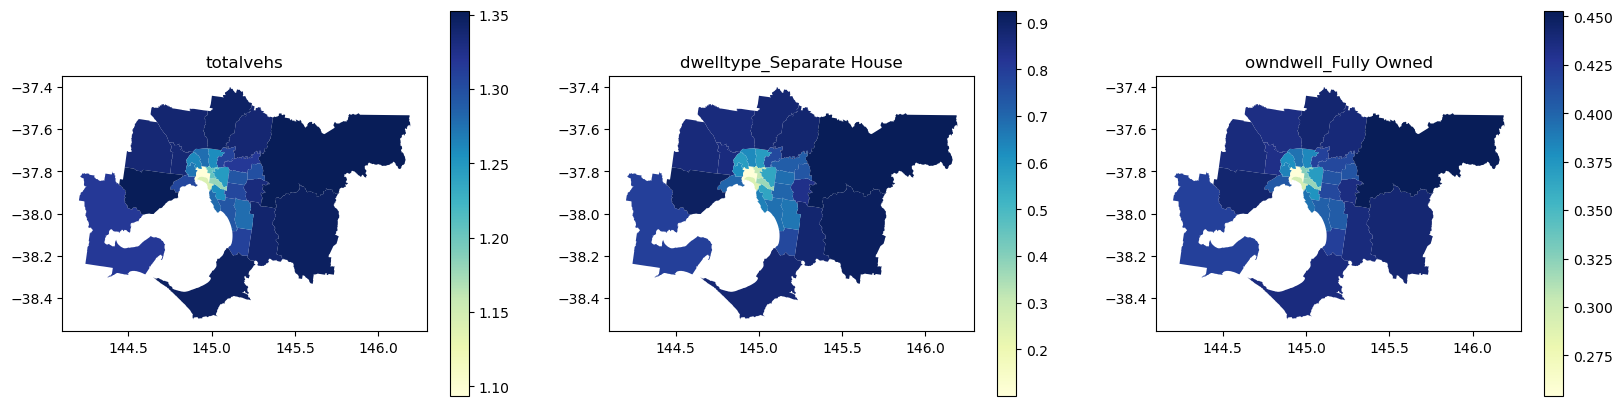

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Vehicles 
totalvehs_by_lga = df.groupby('LGA')['totalvehs'].mean().reset_index()
lga_with_totalvehs= victoria.merge(totalvehs_by_lga, left_on='LGA_NAME22', right_on='LGA', how='inner')
lga_with_totalvehs.plot(column='totalvehs', cmap='YlGnBu', legend=True, ax=axs[0])
# Dwelltype
sepHouse_by_lga = df.groupby('LGA')['dwelltype_Separate House'].mean().reset_index()
lga_with_sepHouse= victoria.merge(sepHouse_by_lga, left_on='LGA_NAME22', right_on='LGA', how='inner')
lga_with_sepHouse.plot(column='dwelltype_Separate House', cmap='YlGnBu', legend=True, ax=axs[1])
# Fully Own
ownHouse_by_lga = df.groupby('LGA')['owndwell_Fully Owned'].mean().reset_index()
lga_with_ownHouse= victoria.merge(ownHouse_by_lga, left_on='LGA_NAME22', right_on='LGA', how='inner')
lga_with_ownHouse.plot(column='owndwell_Fully Owned', cmap='YlGnBu', legend=True, ax=axs[2])

axs[0].set_title('totalvehs')
axs[1].set_title('dwelltype_Separate House')
axs[2].set_title('owndwell_Fully Owned')

plt.show()

# Income

In [15]:
hhinc_by_lga = df.groupby('LGA')['hhinc'].mean().reset_index()
lga_with_hhinc = victoria.merge(hhinc_by_lga, left_on='LGA_NAME22', right_on='LGA', how='inner')

In [16]:
hhinc_90th_percentile = np.percentile(df["hhinc"], 90)
count_greater_90th_percentile = df[df['hhinc'] >= hhinc_90th_percentile].groupby('LGA').size().reset_index(name='highinccount')
df_highinc = count_greater_90th_percentile[['LGA', 'highinccount']]
lga_with_high_hhinc = victoria.merge(df_highinc, left_on='LGA_NAME22', right_on='LGA', how='inner')

In [22]:
count_per_lga = df.groupby('LGA').size().reset_index(name='count')
count_per_lga = count_per_lga[['LGA', 'count']]
df_highinc['percent'] = round(df_highinc['highinccount'] / count_per_lga['count'] *100, 2)
lga_with_high_hhinc = victoria.merge(df_highinc, left_on='LGA_NAME22', right_on='LGA', how='inner')

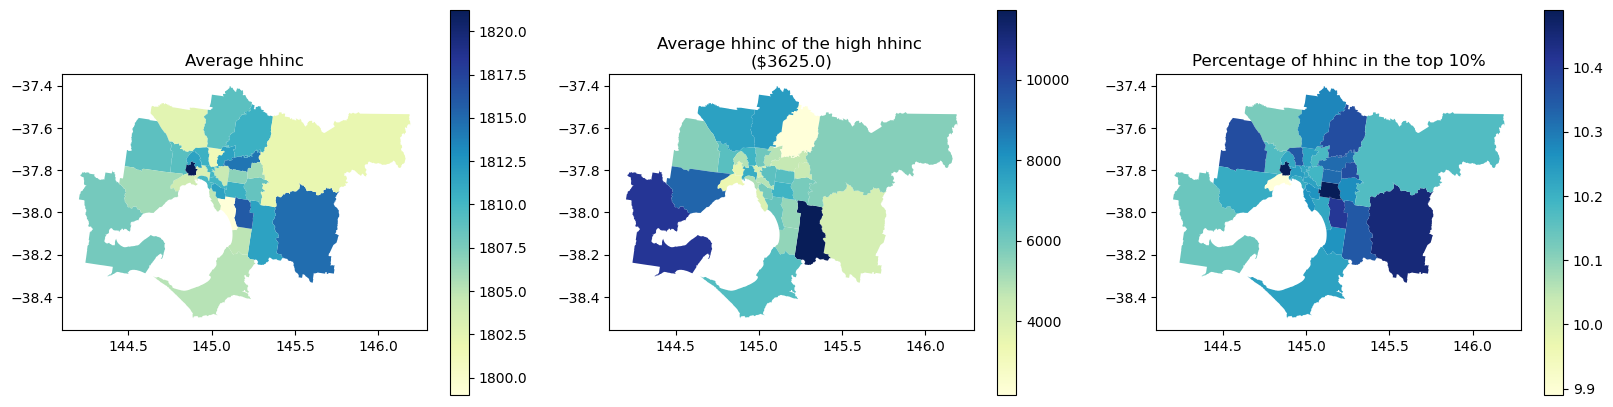

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

lga_with_hhinc.plot(column='hhinc', cmap='YlGnBu', legend=True, ax=axs[0])
lga_with_high_hhinc.plot(column='highinccount', cmap='YlGnBu', legend=True,  ax=axs[1])
lga_with_high_hhinc.plot(column='percent', cmap='YlGnBu', legend=True,  ax=axs[2])
axs[0].set_title('Average hhinc')
axs[1].set_title(f'Average hhinc of the high hhinc \n(${hhinc_90th_percentile})')
axs[2].set_title(f'Percentage of hhinc in the top 10%')
plt.show()

<Axes: ylabel='Frequency'>

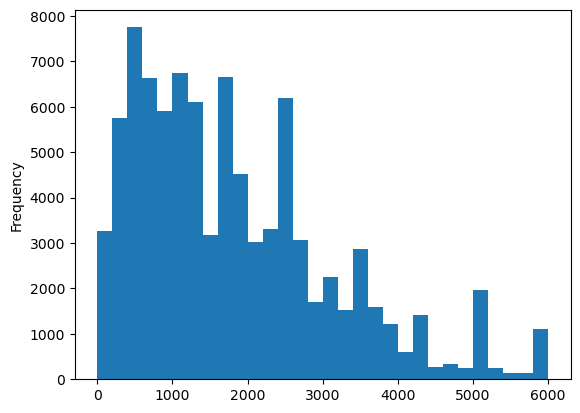

In [24]:
wyndham_df = df[df['LGA'] == 'Wyndham']
wyndham_df['hhinc'].plot(kind='hist', bins=30)

<Axes: ylabel='Frequency'>

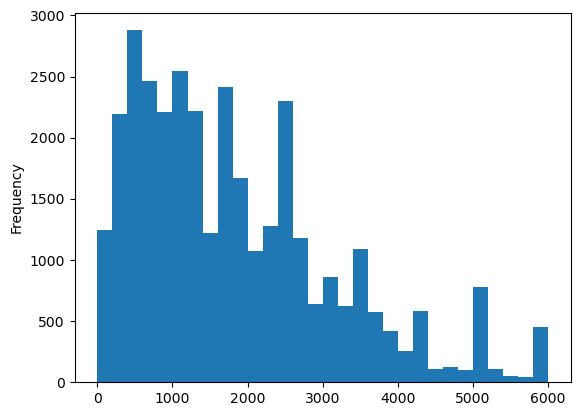

In [25]:
maribyrnong_df = df[df['LGA'] == 'Maribyrnong']
maribyrnong_df['hhinc'].plot(kind='hist', bins=30)

<Axes: ylabel='Frequency'>

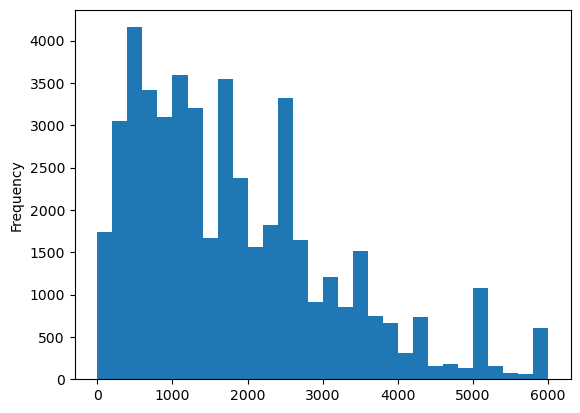

In [26]:
banyule = df[df['LGA'] == 'Banyule']
banyule['hhinc'].plot(kind='hist', bins=30)